In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, classification_report, f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
plt.style.use('seaborn')

Importa il dataset

In [2]:
data = pd.read_csv('Data/25day_dataset.csv')

Funzione di Preprocessing per la verifica sulla presenza di dati NULL all'interno del dataset

In [5]:
def verify_Null(data):
    print("Verifying if the data contains NULL values...")
    x= data.isnull()
    #Conta i record in cui compare True
    nl=len(x[x.eq(True).any(1)])
    if nl>0:
        print(f"A total of {nl} NULL values have been found")
        return True
    else:
        print("No NULL values found in the dataset")
        return False
verify_Null(data)

Verifying if the data contains NULL values...
No NULL values found in the dataset


False

Funzione di Preprocessing che prende i percentili piu alti e piu bassi a partire dalla soglia fornita ed elimina i record con valori maggiori o minori.  

In [41]:
def percentile_Preprocessing(df, treshold):
    #DF per i valori da eliminare
    to_drop= pd.DataFrame()
    #Prendiamo lo 0.001 percento di valori piu grandi e piu piccoli per ogni colonna e aggiungili ad un DF temporaneo
    for col in df.columns[15:]:
        print(f"Working on {col} column...")
        #q= df[f'{col}'].quantile(1-treshold)
        q1= df[f'{col}'].quantile(0+treshold)
        Q= df[(df[f'{col}']<q1)] #| (df[f'{col}']>q)
        #Aggiungi il DF temporaneo al DF per i valori da eliminare senza i duplicati 
        to_drop= pd.concat([to_drop,Q]).drop_duplicates()
        print(f"Removing {len(Q)} values...")
    #Ripulisci dai valori scelti il DF di partenza
    df.drop(to_drop.index, inplace=True)
    print(f"Total values removed: {len(to_drop)} values")
    print(f"Total values remaining in dataset: {len(df)} values")
    return df

Funzione per eliminare i campioni con Active power minore del consumo degli elettrodomestici con l'aggiunta di una soglia di tolleranza

In [372]:
def active_Power_Preprocessing(df, threshold):
    print("Deleting all records with Active Power lower then the power consumed by one of the machines")
    print(f"The chosen threshold is {threshold}")
    #Prendi i record con Active power minore del consumo degli elettrodomestici con una tolleranza definita dalla soglia
    x = df[(df['ActivePower'] + threshold < df['dishwasher']) | 
           (df['ActivePower'] + threshold < df['wahing_machine']) | 
           (df['ActivePower'] + threshold < df['oven'])] 
    print(f"{len(x)} records have been deleted")
    df.drop(x.index, inplace= True)
    print(f"A total of {len(df)} records remain in the dataset")

Con i boxplot cerchiamo di vedere quali features possono essere sfruttate per fare datacleaning

C:\Users\massi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


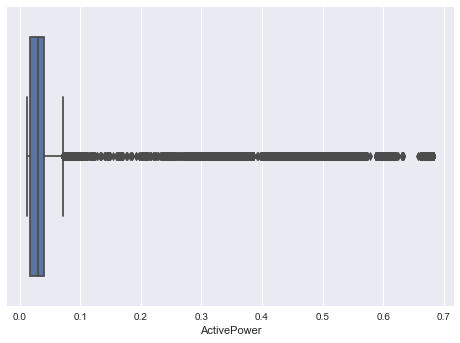

C:\Users\massi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


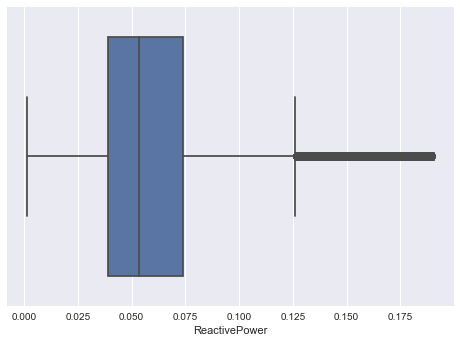

In [373]:
l= ['ActivePower', 'ReactivePower']
for plot in l:   
    ax = sns.boxplot(data[plot])
    plt.show()

Facciamo Outlier detection su valori estremi per le prime due colonne eliminando valori alti di potenza attiva 
e reattiva quando i 3 elettrodomestici sono spenti. Le soglie scelte potrebbero non essere corrette per via della mancanza di conoscenza del dominio

In [378]:
def all_Off_Preprocessing(df):
    print("Deleting high values of Active Power or Reactive Power with all devices OFF..")
    x = df[(df['ActivePower']>0.5) | (df['ReactivePower']<-0.1) | (df['ReactivePower']>=0.3)] 
    outliers_AP= x[(x['wahing_machine']==0) & (x['dishwasher']==0) & (x['oven']==0)]
    print(f"Deleting a total of {len(outliers_AP)} values")
    df.drop(outliers_AP.index, axis=0, inplace=True)

Deleting high values of Active Power or Reactive Power with all devices OFF..
Deleting a total of 4189 values


Si etichetta il dataset con 4 classi:

    1) Tutti spenti [0]
    2) Solo lavatrice accesa [1]
    3) Solo lavastoviglie accesa [2]
    4) Solo forno acceso [3]

In [3]:
label = []
for i in range(len(data)):
    if data['wahing_machine'].iloc[i]==0 and data['dishwasher'].iloc[i]==0 and data['oven'].iloc[i]==0:
        label.append(0)
    elif data['wahing_machine'].iloc[i]>0:
        label.append(1)
    elif data['dishwasher'].iloc[i]>0:
        label.append(2)
    elif data['oven'].iloc[i]>0:
        label.append(3)
data['Class'] = label

Codice per la creazione delle fold di seguito le istruzioni fronite per effettuare il corretto folding:

Test set fold 01: 
Tutte le misure del giorno 2022-01-01


Test set fold 02: 
Tutte le misure del giorno 2022-01-02

Test set fold 03: 
Tutte le misure del giorno 2022-01-03

…..


Test set fold 09: 
Tutte le misure del giorno 2022-01-10
Tutte le misure del giorno 2022-01-11

Test set fold 10: 
Tutte le misure del giorno 2022-01-12
Tutte le misure del giorno 2022-01-13 (dati disponibili fino alle 03:16)


In [4]:
Test_set1 =data[data['DateTime'].str.startswith('2022-01-01')]
Test_set2 =data[data['DateTime'].str.startswith('2022-01-02')]
Test_set3 =data[data['DateTime'].str.startswith('2022-01-03')]
Test_set4 =data[data['DateTime'].str.startswith('2022-01-04')]
Test_set5 =data[data['DateTime'].str.startswith('2022-01-05')]
Test_set6 =data[data['DateTime'].str.startswith('2022-01-06')]
Test_set7 =data[data['DateTime'].str.startswith('2022-01-07')]
Test_set8 =data[(data['DateTime'].str.startswith('2022-01-08')) | (data['DateTime'].str.startswith('2022-01-09'))]
Test_set9 =data[(data['DateTime'].str.startswith('2022-01-10')) | (data['DateTime'].str.startswith('2022-01-11'))]
Test_set10 =data.loc[(data['DateTime']>'2022-01-12')&(data['DateTime']<='2022-01-13 03:17:00')]
test_set_list= [Test_set1, Test_set2, Test_set3, Test_set4, Test_set5, Test_set6, Test_set7, Test_set8, Test_set9, Test_set10]

Funzione per la creazione del training set per addestramenti esterni

In [5]:
def create_Training_set(data, test_set_list):
    Training_set = data.copy()
    for i in range(len(test_set_list)):
        Training_set.drop(test_set_list[i].index, axis=0, inplace=True)
    return Training_set

In [6]:
df= create_Training_set(data, test_set_list)
y= df.Class

In [12]:
len(y.loc[y==1])

44327

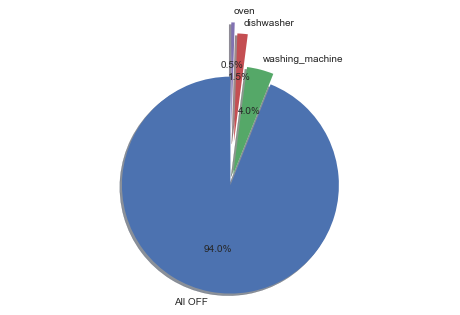

In [13]:
labels = 'All OFF', 'washing_machine', 'dishwasher', 'oven'
sizes = [len(y.loc[y==0]), len(y.loc[y==1]), len(y.loc[y==2]), len(y.loc[y==3])]
explode = (0, 0.1, 0.4, 0.5)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


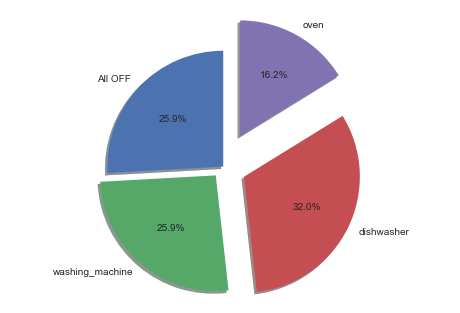

In [24]:
X= df.copy() 
two= len(y.loc[y==2])-6000
three= len(y.loc[y==3])
undersample = RandomUnderSampler(sampling_strategy={0: 9000, 1: 9000, 2: two, 3: three})
X_new, y_new = undersample.fit_resample(X, y)
labels = 'All OFF', 'washing_machine', 'dishwasher', 'oven'
sizes = [len(y_new.loc[y_new==0]), len(y_new.loc[y_new==1]), len(y_new.loc[y_new==2]), len(y_new.loc[y_new==3])]
explode = (0, 0.1, 0.2, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Funzione per il training fuori dal ciclo(prendo solo gli ultimi 12 giorni, addestro il modello e poi lo uso per fare le prediction sulle varie fold): Senza Undersampling risulta sbilanciato con prestazioni non buone. Sto utilizzando i parametri migliori usciti dalla validation fatta

In [ ]:
def train_outside(data, test_set_list):
    Training_set = create_Training_set(data, test_set_list)
    X = Training_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
    y = Training_set.Class
    
    plot = data.plot.pie(y='Class')
    
    two= int((y_train.values == 2).sum())
    three= int((y_train.values == 3).sum())
    undersample = RandomUnderSampler(sampling_strategy={0: 15000, 1: 15000, 2: two, 3: three})
    X_new, y_new = undersample.fit_resample(X_train, y_train)
    
    model = RandomForestClassifier(class_weight= {0: 3, 1: 1, 2: 1, 3: 1},
                                   criterion= 'entropy', 
                                   max_depth= 25, 
                                   max_features= 'sqrt',
                                   max_samples= 0.5,
                                   n_estimators= 50)        
    model.fit(X_train, y_train)
    
    f_score = {}
    recall = {}
    for i in range(len(test_set_list)):
        X_test = test_set_list[i].copy().drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
        y_preds = model.predict(X_test)
        y_test = test_set_list[i].Class
        print("CM:\n" + str(confusion_matrix(y_test,y_preds)) + "\n")
        print(classification_report(y_test,y_preds))
        r = recall_score(y_test,y_preds, average= None) 
        f = f1_score(y_test,y_preds, average= None)
        f_score[i] = f
        recall[i] = r 
    f= pd.DataFrame.from_dict(f_score, orient='index').replace(0, np.nan)
    print(f.mean(axis=0, skipna=True))
    r= pd.DataFrame.from_dict(recall, orient='index').replace(0, np.nan)
    print(r.mean(axis=0, skipna=True))
    
train_outside(data, test_set_list)

Oversampling sulle classi minoritarie e undersampling per le classi maggioritarie in modo da avere un dataset bilanciato. I parametri della RF sono statu tunati nel validation

In [44]:
#Oversample pesante su classi minoritarie

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
f_score={}
recall={}
for i in range(len(test_set_list)):
    #Crea il Training set togliendo dal dataset il Test set
    Test_set= test_set_list[i]
    Training_set= data.drop(Test_set.index, axis=0)
    
    percentile_Preprocessing(Training_set, 0.01)
    #Assegna x e y di training togliendo le colonne non utili
    X= Training_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
    y= Training_set.Class
    n= (y.values == 0).sum()
    one=int((y.values == 1).sum())
    two= int((y.values == 2).sum()*2)
    three= int((y.values == 3).sum()*3)
    over = RandomOverSampler(sampling_strategy={0: n, 1: one, 2: two, 3: three})
    X_, y_ = over.fit_resample(X, y)
    #Fai undersample sulle x e y di train
    n= 40000
    undersample = RandomUnderSampler(sampling_strategy={0: n, 1: one, 2: two, 3: three})
    X_new, y_new = undersample.fit_resample(X_, y_)
    
    #Fitta il modello con una RandomForest
    clf = RandomForestClassifier(class_weight= {0: 10, 1: 1, 2: 2, 3: 2},
                                   criterion= 'entropy', 
                                   max_depth= 20,
                                   max_features= 'sqrt',
                                   max_samples= 0.5,
                                   n_estimators= 35 
                                )
    clf.fit(X_new, y_new)
    y_preds= clf.predict(Test_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1))
    
    #Stampa le statistiche per la fold e memorizza le metriche di f1score e recall
    print("CM:\n" + str(confusion_matrix(Test_set.Class,y_preds)) + "\n")
    print(classification_report(Test_set.Class,y_preds))
    r = recall_score(Test_set.Class,y_preds, average= None) 
    f = f1_score(Test_set.Class,y_preds, average= None)
    f_score[i] = f
    recall[i] = r 
    
end = time.time()
print(f"Time elapsed: {end - start}")
d= pd.DataFrame.from_dict(f_score, orient='index').replace(0, np.nan)
print(d.mean(axis=0, skipna=True))
d= pd.DataFrame.from_dict(recall, orient='index').replace(0, np.nan)
print(d.mean(axis=0, skipna=True))

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2073600 values
CM:
[[79679   768  1205    13]
 [   44  4009     0     0]
 [    0     0     0     0]
 [  141     2     0   539]]

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     81665
           1       0.84      0.99      0.91      4053
           2       0.00      0.00      0.00         0
           3       0.98      0.79      0.87       682

    accuracy                           0.97     86400
   macro avg       0.70      0.69      0.69     86400
weighted avg       0.99      0.97      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2073600 values
CM:
[[76464  1314   343   148]
 [  289  6718     1     0]
 [    0     0     0     0]
 [   79     0     0  1044]]

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     78269
           1       0.84      0.96      0.89      7008
           2       0.00      0.00      0.00         0
           3       0.88      0.93      0.90      1123

    accuracy                           0.97     86400
   macro avg       0.68      0.72      0.70     86400
weighted avg       0.98      0.97      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2073600 values
CM:
[[66945 12756  1169   225]
 [    8  1015     1     0]
 [  652   134  2788     3]
 [    0     0     0   704]]

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     81095
           1       0.07      0.99      0.14      1024
           2       0.70      0.78      0.74      3577
           3       0.76      1.00      0.86       704

    accuracy                           0.83     86400
   macro avg       0.63      0.90      0.66     86400
weighted avg       0.97      0.83      0.88     86400

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2073600 values
CM:
[[79814   619  1248    74]
 [    0     0     0     0]
 [    0     0     0     0]
 [  659  1543 

C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2073600 values
CM:
[[80924  1123   682     6]
 [   67  3598     0     0]
 [    0     0     0     0]
 [    0     0     0     0]]

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     82735
           1       0.76      0.98      0.86      3665
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.98     86400
   macro avg       0.44      0.49      0.46     86400
weighted avg       0.99      0.98      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2073600 values
CM:
[[79207  3020   162    33]
 [    0     0     0     0]
 [   26   654  3297     1]
 [    0     0     0     0]]

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     82422
           1       0.00      0.00      0.00         0
           2       0.95      0.83      0.89      3978
           3       0.00      0.00      0.00         0

    accuracy                           0.95     86400
   macro avg       0.49      0.45      0.47     86400
weighted avg       1.00      0.95      0.98     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2073600 values
CM:
[[79159  1078   654    65]
 [  145  3113     0     0]
 [    0     0     0     0]
 [  636    18     5  1527]]

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     80956
           1       0.74      0.96      0.83      3258
           2       0.00      0.00      0.00         0
           3       0.96      0.70      0.81      2186

    accuracy                           0.97     86400
   macro avg       0.67      0.66      0.66     86400
weighted avg       0.98      0.97      0.97     86400



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 1987200 values
CM:
[[157919   1230    775    993]
 [   387   7056      1      0]
 [  1067    346   2217      3]
 [    64     61      0    681]]

              precision    recall  f1-score   support

           0       0.99      0.98      0.99    160917
           1       0.81      0.95      0.87      7444
           2       0.74      0.61      0.67      3633
           3       0.41      0.84      0.55       806

    accuracy                           0.97    172800
   macro avg       0.74      0.85      0.77    172800
weighted avg       0.97      0.97      0.97    172800

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 1987200 values
CM:
[[164753   2668    710    100]
 [    63   2727      0      0]
 [     0      0  

C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Working on oven column...
Removing 0 values...
Working on Class column...
Removing 0 values...
Total values removed: 0 values
Total values remaining in dataset: 2061779 values
CM:
[[90667   748   736   303]
 [   70  4291     0     0]
 [    0     0     0     0]
 [   77     1     0  1328]]

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     92454
           1       0.85      0.98      0.91      4361
           2       0.00      0.00      0.00         0
           3       0.81      0.94      0.87      1406

    accuracy                           0.98     98221
   macro avg       0.67      0.73      0.69     98221
weighted avg       0.99      0.98      0.98     98221

Time elapsed: 80.91184425354004
0    0.977193
1    0.760350
2    0.765281
3    0.783083
dtype: float64
0    0.961267
1    0.973179
2    0.739491
3    0.790179
dtype: float64


C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

#Per fare prove varie

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import time
start = time.time()
f_score={}
recall={}
for i in range(0,9):
    #Crea il Training set togliendo dal dataset il Test set
    Test_set= test_set_list[i]
    Training_set= data.drop(Test_set.index, axis=0)
    
    #Preprocessing sul Training set 
    #active_Power_Preprocessing(Training_set, 0.001) #Peggiora le performance
    #all_Off_Preprocessing(Training_set) #Peggiora le performance
    #Training_set= percentile_Preprocessing(Training_set) #MEH
    
    #Assegna x e y di training togliendo le colonne non utili
    X= Training_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
    y= Training_set.Class
    one= int((y.values == 1).sum()*0.5) #migliora f score abbassare i campioni calsse 1
    two= int((y.values == 2).sum())
    three= int((y.values == 3).sum())
    #Fai undersample sulle x e y di train
    n= 80000
    undersample = RandomUnderSampler(sampling_strategy={0: n, 1: one, 2: two, 3: three})
    X_new, y_new = undersample.fit_resample(X, y)
    
    #Fitta il modello con una RandomForest
    clf= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    #clf = RandomForestClassifier(max_depth=25, n_estimators=10, max_features=None, warm_start=True, class_weight= {0: 0.1, 1: 3, 2: 4, 3: 5})
    clf.fit(X_new, y_new)
    y_preds= clf.predict(Test_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1))
    
    #Stampa le statistiche per la fold e memorizza le metriche di f1score e recall
    print("CM:\n" + str(confusion_matrix(Test_set.Class,y_preds)) + "\n")
    print(classification_report(Test_set.Class,y_preds))
    r = recall_score(Test_set.Class,y_preds, average= None) 
    f = f1_score(Test_set.Class,y_preds, average= None)
    f_score[i] = f
    recall[i] = r 
    
end = time.time()
print(f"Time elapsed: {end - start}")

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
f_score={}
recall={}
for i in range(0,9):
    #Crea il Training set togliendo dal dataset il Test set
    Test_set= test_set_list[i]
    Training_set= data.drop(Test_set.index, axis=0)
    
    #Preprocessing sul Training set 
    active_Power_Preprocessing(Training_set, 0.0001)
    all_Off_Preprocessing(Training_set)
    
    #Assegna x e y di training togliendo le colonne non utili
    X= Training_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
    y= Training_set.Class
    
    #Fai undersample sulle x e y di train
    n= 200000 - (y.values == 1).sum() - (y.values == 3).sum() - (y.values == 2).sum()
    undersample = RandomUnderSampler(sampling_strategy={0: n, 1: (y.values == 1).sum(), 2: (y.values == 2).sum(), 3: (y.values == 3).sum()})
    X_new, y_new = undersample.fit_resample(X, y)
    
    #Fitta il modello con una RandomForest
    clf = RandomForestClassifier(max_depth=10, n_estimators=50, max_features=n_features)
    clf.fit(X_new, y_new)
    y_preds= clf.predict(Test_set.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1))
    
    #Stampa le statistiche per la fold e memorizza le metriche di f1score e recall
    print("CM:\n" + str(confusion_matrix(Test_set.Class,y_preds)) + "\n")
    print(classification_report(Test_set.Class,y_preds))
    r = recall_score(Test_set.Class,y_preds, average= None) 
    f = f1_score(Test_set.Class,y_preds, average= None)
    f_score[i] = f
    recall[i] = r 
    
end = time.time()
print(f"Time elapsed: {end - start}")

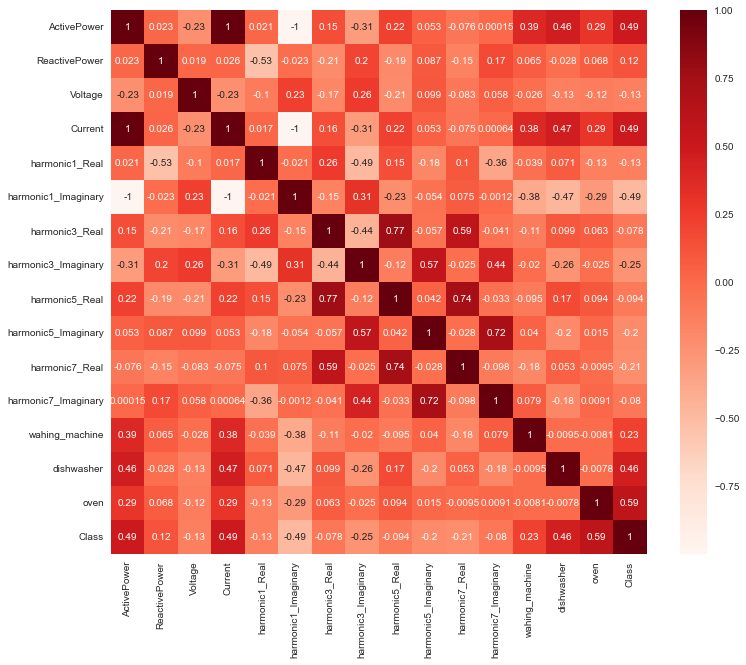

In [365]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Boxplot
ax = sns.boxplot(data=data)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [113]:
data.describe()

,ActivePower,ReactivePower,Voltage,Current,harmonic1_Real,harmonic1_Imaginary,harmonic3_Real,harmonic3_Imaginary,harmonic5_Real,harmonic5_Imaginary,harmonic7_Real,harmonic7_Imaginary,wahing_machine,dishwasher,oven,Class
count,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06,2.160000e+06
mean,5.258496e-02,5.824834e-02,1.643660e-04,6.882403e-04,-1.401351e-05,-7.444505e-04,1.675327e-05,-5.565177e-05,-9.542361e-06,-1.558759e-05,-5.240636e-06,-7.482664e-06,3.178948e-03,3.994824e-03,1.986789e-03,8.864815e-02
std,8.616703e-02,2.881432e-02,1.026790e-06,1.126564e-03,9.869257e-05,1.238098e-03,1.762530e-05,3.219977e-05,8.561618e-06,9.119885e-06,4.873613e-06,5.488337e-06,3.208444e-02,4.187745e-02,2.445150e-02,3.996259e-01
min,0.000000e+00,-5.350264e-01,1.584105e-04,1.507003e-04,-2.513540e-03,-1.439363e-02,-4.871474e-04,-6.168197e-04,-1.415882e-04,-1.850459e-04,-6.939222e-05,-1.058407e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.763959e-02,3.900889e-02,1.640180e-04,2.285037e-04,-7.429874e-05,-5.635489e-04,9.112109e-06,-6.939222e-05,-1.261677e-05,-1.962608e-05,-7.710246e-06,-1.121490e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.989994e-02,5.338732e-02,1.640180e-04,3.911198e-04,0.000000e+00,-4.198579e-04,1.401863e-05,-4.415868e-05,-1.051397e-05,-1.401863e-05,-4.906520e-06,-7.009315e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.005724e-02,7.413507e-02,1.654198e-04,5.235958e-04,2.873819e-05,-2.439242e-04,2.242981e-05,-3.364471e-05,-6.308383e-06,-9.813041e-06,-2.102794e-06,-3.504657e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.114534e+00,1.682236e-04,1.327704e-02,7.030343e-04,5.677545e-05,3.301387e-04,2.915875e-04,8.481271e-05,1.282705e-04,6.588756e-05,4.906520e-05,4.427968e-01,4.662008e-01,3.282755e-01,3.000000e+00


In [298]:
one= int((y.values == 1).sum()) #migliora f score abbassare i campioni calsse 1
two= int((y.values == 2).sum())
three= int((y.values == 3).sum())
print(one, two, three)
x=list[one, two, three]

70204 21656 16887


In [353]:
X.head()

,ActivePower,ReactivePower,Voltage,Current,harmonic1_Real,harmonic1_Imaginary,harmonic3_Real,harmonic3_Imaginary,harmonic5_Real,harmonic5_Imaginary,harmonic7_Real,harmonic7_Imaginary
0,0.019520,0.035852,0.000165,0.000253,0.000011,-0.000271,0.000009,-0.000054,-0.000013,-0.000022,-3.504657e-06,-0.000011
1,0.019627,0.036632,0.000165,0.000254,0.000010,-0.000273,0.000009,-0.000055,-0.000013,-0.000023,-9.112109e-06,-0.000011
2,0.019411,0.036640,0.000165,0.000252,0.000010,-0.000268,0.000008,-0.000054,-0.000013,-0.000023,-5.607452e-06,-0.000016
3,0.019411,0.036637,0.000165,0.000252,0.000012,-0.000268,0.000008,-0.000053,-0.000013,-0.000022,-4.906520e-06,-0.000009
4,0.019735,0.036645,0.000165,0.000256,0.000013,-0.000277,0.000009,-0.000056,-0.000013,-0.000024,-5.607452e-06,-0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...
2159995,0.016614,0.049226,0.000163,0.000217,0.000021,-0.000233,0.000011,-0.000045,-0.000011,-0.000018,-6.308383e-06,-0.000007
2159996,0.016512,0.050061,0.000163,0.000216,0.000021,-0.000232,0.000011,-0.000044,-0.000011,-0.000018,-2.803726e-06,-0.000006
2159997,0.016713,0.048425,0.000163,0.000219,0.000020,-0.000236,0.000011,-0.000046,-0.000011,-0.000019,-7.009315e-07,-0.000009
2159998,0.016617,0.049573,0.000163,0.000217,0.000020,-0.000231,0.000011,-0.000044,-0.000011,-0.000018,-1.401863e-06,-0.000008
